1. Import Libraries and Initial steps

In [1]:
import warnings                      #to remove warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt      #For visualization
import seaborn as sns                #Also for visualization

plt.style.use('fivethirtyeight')     #Style we are using for visualizaton
%matplotlib inline
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
print(train.shape)

(891, 12)


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [4]:
train.isnull().sum()

,0
PassengerId,0
Survived,0
Pclass,0
Name,0
Sex,0
Age,177
SibSp,0
Parch,0
Ticket,0
Fare,0




---

2. Data Visualization: Understanding Survival Trends and Passenger Demographics

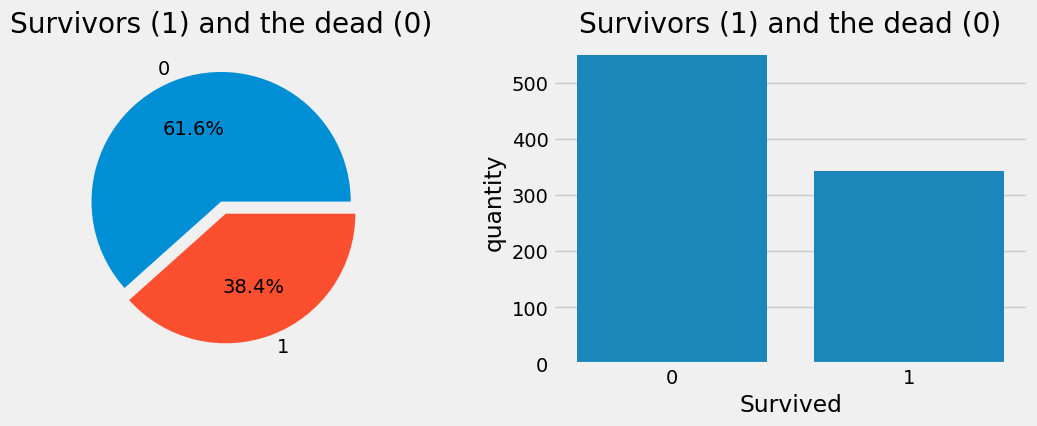

In [5]:
f, ax = plt.subplots(1, 2, figsize=(12, 4))

train['Survived'].value_counts().plot.pie(explode=[0, 0.1], autopct='%1.1f%%', ax=ax[0], shadow=False)
ax[0].set_title('Survivors (1) and the dead (0)')
ax[0].set_ylabel('')
sns.countplot(x='Survived', data = train, ax=ax[1])
ax[1].set_ylabel('quantity')
ax[1].set_title('Survivors (1) and the dead (0)')
plt.show()

Total number of survivors and deceased in total populaton of the titanic boat

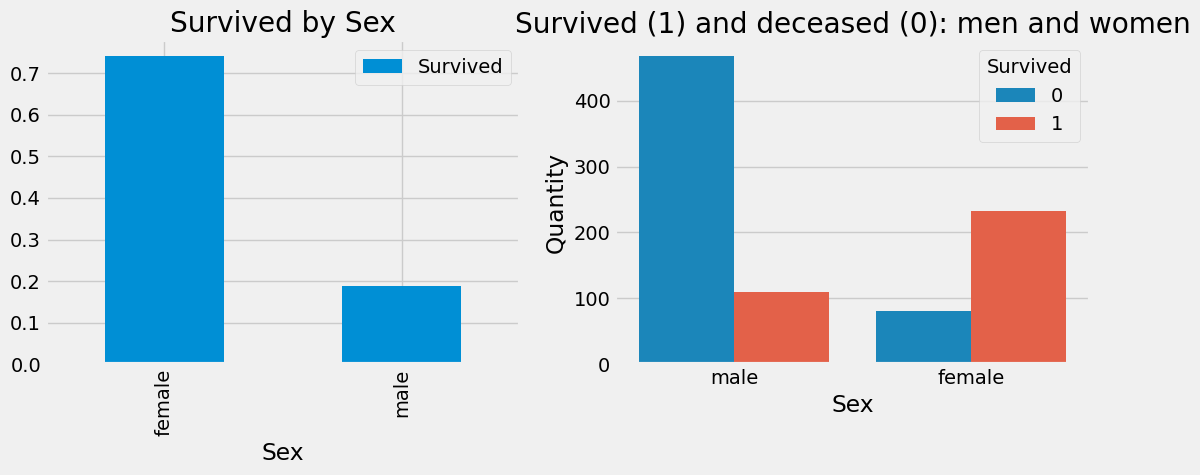

In [6]:
f, ax = plt.subplots(1, 2, figsize=(12, 4))
train[['Sex','Survived']].groupby(['Sex']).mean().plot.bar(ax=ax[0])
ax[0].set_title('Survived by Sex')
sns.countplot(x='Sex', hue='Survived', data=train, ax= ax[1])
ax[1].set_ylabel("Quantity")
ax[1].set_title("Survived (1) and deceased (0): men and women")
plt.show()

Men vs Women survival count during titanic accident

---

3. Feature Engineering: Optimizing Data for Model Training

In [7]:
train = train.drop(['Cabin','Ticket'], axis = 1)
test = test.drop(['Cabin','Ticket'], axis = 1)

We removed Cabin and Ticket column since its very unlikely to be useful for training.

In [8]:
print(train.isnull().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Fare             0
Embarked         2
dtype: int64


In [9]:
train = train.fillna({"Embarked":'S'})     #fills the specific column having null with the given value
# print(train.isnull().sum())    #no more null values in Embark (uncomment and confirm it.)

Now we will sort the age of people into age-groups. So that we have fewer catergories to work with and helps for better prediction of the model

In [11]:
train["Age"] = train["Age"].fillna(-0.5)
test["Age"] = test["Age"].fillna(-0.5)

bins = [-1, 0, 5, 12, 18, 24, 35, 60, np.inf]
labels = ['Unknown', 'Babies', 'Child', 'Teenagers', 'Student',"Young Adult",'Adult','Senior']
train['AgeGroup'] = pd.cut(train["Age"], bins, labels = labels)
test['AgeGroup'] = pd.cut(test["Age"], bins, labels = labels)


In [12]:
print(train['AgeGroup'])
print(test['AgeGroup'])

0          Student
1            Adult
2      Young Adult
3      Young Adult
4      Young Adult
          ...     
886    Young Adult
887        Student
888        Unknown
889    Young Adult
890    Young Adult
Name: AgeGroup, Length: 891, dtype: category
Categories (8, object): ['Unknown' < 'Babies' < 'Child' < 'Teenagers' < 'Student' < 'Young Adult' <
                         'Adult' < 'Senior']
0      Young Adult
1            Adult
2           Senior
3      Young Adult
4          Student
          ...     
413        Unknown
414          Adult
415          Adult
416        Unknown
417        Unknown
Name: AgeGroup, Length: 418, dtype: category
Categories (8, object): ['Unknown' < 'Babies' < 'Child' < 'Teenagers' < 'Student' < 'Young Adult' <
                         'Adult' < 'Senior']


A new age group has been formed with corresponding bin values

In [13]:
combine = [train, test]
# print(type(combine))
for dataset in combine:
  dataset['Title'] = dataset.Name.str.extract('([A-Za-z]+)\.',expand = False)

print(dataset['Title'].unique())

['Mr' 'Mrs' 'Miss' 'Master' 'Ms' 'Col' 'Rev' 'Dr' 'Dona']


In [14]:
pd.crosstab(train['Title'], train['Sex'])     #to crosstab the Title with Sex column

for dataset in combine:
  dataset['Title'] = dataset['Title'].replace(['Lady','Capt','Col','Don','Dr','Major','Rev','Jonkheer','Dona'],'Rare')

  dataset['Title'] = dataset['Title'].replace(['Countess','Lady','Sir'],'Royal')
  dataset['Title'] = dataset['Title'].replace('Mlle','Miss')
  dataset['Title'] = dataset['Title'].replace('Ms','Miss')
  dataset['Title'] = dataset['Title'].replace('Mme','Mrs')

train[['Title','Survived']].groupby(['Title'], as_index = False).mean()

title_mapping = {'Mr':1, "Miss":2, "Mrs":3, "Master":4, "Royal":5, "Rare":6}
for dataset in combine:
  dataset['Title'] = dataset['Title'].map(title_mapping)
  dataset['Title'] = dataset['Title'].fillna(0)

Now we can fill the misiing age values

In [15]:
mr_age = train[train["Title"] == 1]['AgeGroup'].mode()
miss_age = train[train["Title"] == 2]['AgeGroup'].mode()
mrs_age = train[train["Title"] == 3]['AgeGroup'].mode()
master_age = train[train["Title"] == 4]['AgeGroup'].mode()
royal_age = train[train["Title"] == 5]['AgeGroup'].mode()
rare_age = train[train["Title"] == 6]['AgeGroup'].mode()

age_title_mapping = {1:"Young Adult", 2:"Student",3:"Adult",4:"Baby",5:"Adult",6:"Adult"}

for x in range(len(train["AgeGroup"])):
  if train["AgeGroup"][x] == "Unknown":
    train["AgeGroup"][x] == age_title_mapping[train["Title"][x]]

for x in range(len(test["AgeGroup"])):
  if train["AgeGroup"][x] == "Unknown":
    train["AgeGroup"][x] == age_title_mapping[train["Title"][x]]

Now assign a numerical value to each age category. Once we have mapped the age into different categories we do not need the age feature. Hence drop it

In [16]:
age_mapping = {'Baby':1, "Child":2,"Teenager":3,"Student":4,"Young Adult":5,"Adult":6,"Senior":7}

train['AgeGroup'] = train['AgeGroup'].map(age_mapping)
test['AgeGroup'] = test['AgeGroup'].map(age_mapping)

print(train.head())

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch     Fare Embarked  AgeGroup  Title  
0      0   7.2500        S       4.0      1  
1      0  71.2833        C       6.0      3  
2      0   7.9250        S       5.0      2  
3      0  53.1000        S       5.0      3  
4      0   8.0500        S       5.0      1  


In [17]:
#Drop the Age feature for now since it's not useful anymore
train = train.drop(["Age"], axis = 1)
test = test.drop(["Age"], axis = 1)

Now we can also drop the Name column since it has no more useful information

In [18]:
#Drop Name column from train and test
train = train.drop(['Name'], axis =1)
test = test.drop(['Name'], axis =1)

Now assign numerical values to sex and embark categories.

In [19]:
print(train['Sex'],train['Embarked'])

0        male
1      female
2      female
3      female
4        male
        ...  
886      male
887    female
888    female
889      male
890      male
Name: Sex, Length: 891, dtype: object 0      S
1      C
2      S
3      S
4      S
      ..
886    S
887    S
888    S
889    C
890    Q
Name: Embarked, Length: 891, dtype: object


In [20]:
sex_mapping = {'male':0, 'female':1}
train['Sex'] = train['Sex'].map(sex_mapping)
test['Sex'] = test['Sex'].map(sex_mapping)

embark_mapping = {"S": 1, "C":2,"Q":3}
train["Embarked"] = train['Embarked'].map(embark_mapping)
test["Embarked"] = test['Embarked'].map(embark_mapping)

In [21]:
print(train['Sex'],train['Embarked'])

0      0
1      1
2      1
3      1
4      0
      ..
886    0
887    1
888    1
889    0
890    0
Name: Sex, Length: 891, dtype: int64 0      1
1      2
2      1
3      1
4      1
      ..
886    1
887    1
888    1
889    2
890    3
Name: Embarked, Length: 891, dtype: int64


You can observe the how the column [ ' Sex ' , ' Embarked ' ] modified.

In [22]:
for x in range(len(test['Fare'])):
  if pd.isnull(test['Fare'][x]):
    pclass = test['Pclass'][x]
    test['Fare'][x] = round(train[train['Pclass'] == pclass]['Fare'].mean(), 4)

#map fare values into groups of numerical Values
train['RareBand'] = pd.qcut(train['Fare'], 4, labels = [1,2,3,4])
test['RareBand'] = pd.qcut(test['Fare'], 4, labels = [1,2,3,4])

train = train.drop(['Fare'], axis = 1)
test = test.drop(['Fare'], axis = 1)


4. Model Training: building the predictive model

We will be using Random Forest as our algorithm to train the predictive model.

In [26]:
from sklearn.model_selection import train_test_split

#Setting up on columns to be trained with and target column
#then spilt the data into training data and testing data

predictors = train.drop(["Survived","PassengerId"], axis = 1)
target = train["Survived"]

x_train, x_val, y_train, y_val = train_test_split(predictors, target, test_size =0.2, random_state = 0)


In [32]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

randomforest = RandomForestClassifier()

#fit the training data along with its outcome
randomforest.fit(x_train, y_train)
y_pred = randomforest.predict(x_val)

#Find the accuracy score of the model
acc_randomforest = round(accuracy_score(y_pred, y_val)*100,2)
print(acc_randomforest)

84.36


Hence we can say that we got an accuracy of 84.36%

(Since random forest algorithm varies a little but on every run the accuracy may vary a little bit)

In [33]:
ids = test['PassengerId']
predictions = randomforest.predict(test.drop('PassengerId', axis=1))

output = pd.DataFrame({'PassengerId':ids,'Survived':predictions})
output.to_csv('resultfile.csv', index=False)

In [34]:
print(output)

     PassengerId  Survived
0            892         0
1            893         0
2            894         0
3            895         0
4            896         0
..           ...       ...
413         1305         0
414         1306         1
415         1307         0
416         1308         0
417         1309         1

[418 rows x 2 columns]


Thank you for going through my work till the end, you've already made my day and I hope you have a wonderful one.

Feel free to reach out if you have any doubts regarding above work.